# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository.  You have already used this set but this time I have removed  the first column. The set  `banknote_authentication.csv` can be found in the `data`  directory.

In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scrapbook as sb

You will have to install a popular plotting library `seaborn`

In [487]:
data = pd.read_csv('data/banknote_authentication.csv')

In [488]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. Please use `scrapbook` to store your results. 

In [489]:
from sklearn.model_selection import train_test_split
seed = 5555
train_data, test_data  = train_test_split(data,test_size=0.3, random_state=seed)

In [490]:
x_train = train_data[['a1', 'a2', 'a3']]
x_test = test_data[['a1', 'a2', 'a3']]
y_train = train_data['counterfeit']
y_test = test_data['counterfeit']

In [491]:
clf.fit(x_train, y_train)

y_scores_qda = clf.predict_proba(x_test)
y_scores_qda = y_scores_qda[:,1]
y_pred_qda = (y_scores_qda > 0.5).astype(int)

In [492]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

cm_qda = confusion_matrix(y_test, y_pred_qda, normalize='true')

tn, fp, fn, tp = cm_qda.ravel()

tnr = tn/(tn+fp)
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr = tp/(tp+fn)

precision = precision_score(y_test, y_pred_qda, average='weighted')
f1 = f1_score(y_test, y_pred_qda, average='weighted')
fprs, tprs, thds = roc_curve(y_test, y_scores_qda)
auc = roc_auc_score(y_test, y_scores_qda, multi_class = 'ovr')

In [493]:
print("TNR:", tnr)
print("FPR:", fpr)
print("FNR:", fnr)
print("TPR:", tpr)
print("precision:", precision)
print("f1:", f1)
print("auc:", auc)

TNR: 0.8156424581005587
FPR: 0.18435754189944134
FNR: 0.17880794701986755
TPR: 0.8211920529801324
precision: 0.8191658494298308
f1: 0.8184031877213696
auc: 0.9014391949387695


In [494]:
sb.glue('A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

also please save the ROC plot

In [495]:
auc_a = auc
tprs_a = tprs
fprs_a = fprs
tpr_a = tpr
fpr_a = fpr

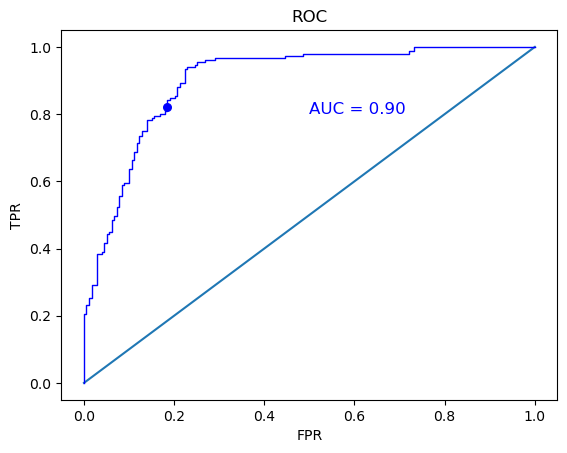

In [496]:
fig, ax = plt.subplots()
ax.set_xlabel('FPR');
ax.set_ylabel('TPR');
ax.set_title('ROC')
ax.plot([0,1],[0,1]);

roc = ax.plot(fprs_a,tprs_a, color='blue', linewidth=1);

ax.scatter([fpr_a],[tpr_a],s = 30, edgecolor='blue', zorder=5, facecolor='blue');
ax.text(0.5, 0.8, "AUC = {:4.2f}".format(auc), fontsize=12, color= 'blue');

sb.glue('A_ROC',fig, "display", display=False);


### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [497]:
from sklearn.mixture import GaussianMixture

In [498]:
cf_gm = GaussianMixture(n_components=2, max_iter=100, tol=0.0001) 
ncf_gm = GaussianMixture(n_components=2, max_iter=100, tol=0.0001) 

In [499]:
cf = x_train[y_train == 1]
ncf = x_train[y_train == 0]

In [500]:
cf_gm.fit(cf)
ncf_gm.fit(ncf)

GaussianMixture(n_components=2, tol=0.0001)

In [501]:
print(cf_gm.weights_)  #pi
print(cf_gm.means_)    #mu
print(cf_gm.covariances_) #Sigma (covariance) matrices

[0.32243335 0.67756665]
[[-7.80964288  8.73456042 -0.30807095]
 [ 2.17975689 -0.87032413 -1.66378601]]
[[[ 7.44910343 -8.24307961  2.49271776]
  [-8.24307961 13.82973202 -3.24001482]
  [ 2.49271776 -3.24001482  1.48327238]]

 [[ 6.53182179 -1.89624398 -4.72696529]
  [-1.89624398  4.13225188  1.50377786]
  [-4.72696529  1.50377786  4.58811762]]]


In [502]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
    
    
def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p
        

In [503]:
mgd_predict_proba = make_predict_proba(ncf_gm, cf_gm, 0.5, 0.5)

In [504]:
y_scores_gm = mgd_predict_proba(x_test)
y_pred_gm = (y_scores_gm > 0.5).astype(int)

In [505]:
cm_gm = confusion_matrix(y_test, y_scores_gm>0.5, normalize='true')

In [506]:
tn, fp, fn, tp = cm_gm.ravel()

tnr = tn/(tn+fp)
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr = tp/(tp+fn)

precision = precision_score(y_test, mgd_proba>0.5, average='weighted')
f1 = f1_score(y_test, mgd_proba>0.5, average='weighted')
fprs, tprs, thds = roc_curve(y_test, mgd_proba)
auc = roc_auc_score(y_test, mgd_proba, multi_class = 'ovr')

In [507]:
print("TNR:", tnr)
print("FPR:", fpr)
print("FNR:", fnr)
print("TPR:", tpr)
print("precision:", precision)
print("f1:", f1)
print("auc:", auc)

TNR: 0.9329608938547486
FPR: 0.0670391061452514
FNR: 0.1456953642384106
TPR: 0.8543046357615894
precision: 0.8979180525279816
f1: 0.8966053476997491
auc: 0.9663694550297828


In [508]:
sb.glue('B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

also please save the ROC plot

In [509]:
auc_b = auc
fpr_b = fpr
tpr_b = tpr
fprs_b = fprs
tprs_b = tprs

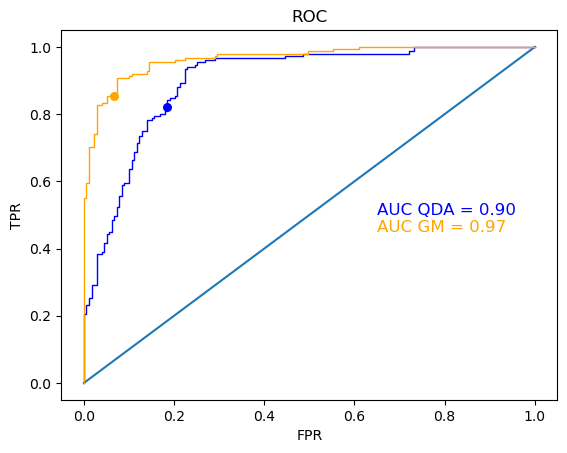

In [510]:
fig, ax = plt.subplots()
ax.set_xlabel('FPR');
ax.set_ylabel('TPR');
ax.set_title('ROC')
ax.plot([0,1],[0,1]);

ax.plot(fprs_a,tprs_a, color='blue', linewidth=1);
ax.scatter([fpr_a],[tpr_a],s = 30, edgecolor='blue', zorder=5, facecolor='blue');

ax.plot(fprs_b,tprs_b, color='orange', linewidth=1);
ax.scatter([fpr_b],[tpr_b],s = 30, edgecolor='orange', zorder=5, facecolor='orange');

ax.text(0.65, 0.5, "AUC QDA = {:4.2f}".format(auc_a), fontsize=12, color='blue');
ax.text(0.65, 0.45, "AUC GM = {:4.2f}".format(auc_b), fontsize=12, color='orange');

sb.glue('B_ROC',fig, "display", display=False);

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. Assume that maximal number of components in each class is 12.  

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

In [511]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [512]:
X = data[['a1', 'a2', 'a3']].values
y = data['counterfeit'].values
skf = StratifiedKFold(n_splits=6)
splits = skf.get_n_splits(X, y)

In [513]:
max_comp = 12
# store the best number of components for each class
best_n_comp = {}  

for label in np.unique(y):
    
    best_f1 = 0.0  
    best_n = None  
    
    for n_comp in range(1, max_comp+1):
        # f1 scores for each fold
        f1_scores = []  
        
        for train_index, test_index in skf.split(X, y):
            
            #print(train_index, test_index)
            X_tr, X_te = X[train_index], X[test_index]
            y_tr, y_te = y[train_index], y[test_index]
            
            # fit gm
            gmm = GaussianMixture(n_components = n_comp)
            gmm.fit(X_tr[y_tr == label]) 
                       
            y_pred = gmm.predict(X_te)
           
            f1score = f1_score(y_te[y_te == label], y_pred[y_te == label], average='weighted')
            f1_scores.append(f1score)
          
        # average accuracy for this number of comp
        avg_f1 = np.mean(f1_scores)
        
        # check accuracy
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_n = n_comp
            
        # reach max n of components
        if n_comp >= max_comp:
            break  
    
    best_n_comp[label] = best_n  # Store the best number of components for the class

print(best_n_comp)

{0: 1, 1: 2}


In [514]:
# save results
n_cpm_neg = best_n_comp[0]  
n_cpm_pos = best_n_comp[1]
best_f1_score = best_f1

In [515]:
#  store the results of the best fit 
sb.glue("C_n_cmp",['n_cmp_pos', 'n_cmp_neg', 'best_f1_score'])

In [516]:
from sklearn.mixture import GaussianMixture

gmm_ncf = GaussianMixture(n_components = n_cpm_neg)
gmm_cf = GaussianMixture(n_components = n_cpm_pos)

gmm_ncf.fit(x_train[y_train == 0])
gmm_cf.fit(x_train[y_train == 1])

GaussianMixture(n_components=2)

In [517]:
y_scores_kf = gmm_cf.predict_proba(x_test)
y_scores_kf = y_scores_kf[:,1]
y_pred_kf = (y_scores_kf > 0.5).astype(int)

In [518]:
cm_kf = confusion_matrix(y_test, y_pred_kf, normalize='true')

Store the results for the best estimator

In [519]:
tn, fp, fn, tp = cm_kf.ravel()

tnr = tn/(tn+fp)
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr = tp/(tp+fn)

precision = precision_score(y_test, y_pred_kf, average='weighted')
f1 = f1_score(y_test, y_pred_kf, average='weighted')
fprs, tprs, thds = roc_curve(y_test, y_scores_kf)
auc = roc_auc_score(y_test, y_scores_kf, multi_class = 'ovr')

In [520]:
print("TNR:", tnr)
print("FPR:", fpr)
print("FNR:", fnr)
print("TPR:", tpr)
print("precision:", precision)
print("f1:", f1)
print("auc:", auc)

TNR: 0.8491620111731844
FPR: 0.15083798882681565
FNR: 0.6158940397350994
TPR: 0.3841059602649007
precision: 0.6487525919458692
f1: 0.6138180655289706
auc: 0.6509674793740057


In [521]:
sb.glue('C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

also please save the ROC plot

In [522]:
auc_c = auc
fpr_c = fpr
tpr_c = tpr
fprs_c = fprs
tprs_c = tprs

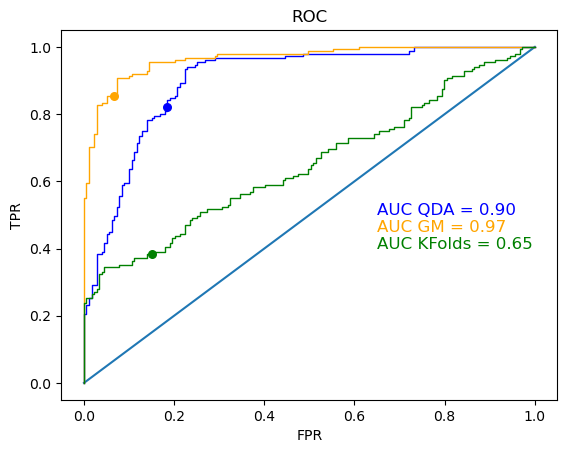

In [523]:
fig, ax = plt.subplots()
ax.set_xlabel('FPR');
ax.set_ylabel('TPR');
ax.set_title('ROC')
ax.plot([0,1],[0,1]);

ax.plot(fprs_a,tprs_a, color='blue', linewidth=1);
ax.scatter([fpr_a],[tpr_a],s = 30, edgecolor='blue', zorder=5, facecolor='blue');

ax.plot(fprs_b,tprs_b, color='orange', linewidth=1);
ax.scatter([fpr_b],[tpr_b],s = 30, edgecolor='orange', zorder=5, facecolor='orange');

ax.plot(fprs_c,tprs_c, color='green', linewidth=1);
ax.scatter([fpr_c],[tpr_c],s = 30, edgecolor='green', zorder=5, facecolor='green');

ax.text(0.65, 0.5, "AUC QDA = {:4.2f}".format(auc_a), fontsize=12, color='blue');
ax.text(0.65, 0.45, "AUC GM = {:4.2f}".format(auc_b), fontsize=12, color='orange');
ax.text(0.65, 0.4, "AUC KFolds = {:4.2f}".format(auc_c), fontsize=12, color='green');

sb.glue('C_ROC',fig, "display", display=False);

## D.  

Assume that 1% of all the customers in your store try to pay with a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

accept counterfeit = false positive
reject valid = false negative

In [524]:
# probability of a customer trying to pay with a counterfeit bill
fp_prob = 0.01  
# loss when accepting a counterfeit bill
fp_loss = 100 
# loss when rejecting a valid bill
fn_loss = 15 

thresholds = np.linspace(0, 1, num=100)  

### QDA

In [525]:
min_loss_qda = float('inf')  
optimal_threshold_qda = None

# first for QDA
for threshold in thresholds:
    y_pred = (y_scores_qda >= threshold).astype(int)

    # true positives, false positives, true negatives, false negatives
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tn, fp, fn, tp = cm.ravel()

    # expected loss 
    expected_loss = (fp * fp_prob * fp_loss) + (fn * fn_loss)
    
    # update minimum loss and optimal threshold 
    if expected_loss < min_loss_qda:
        min_loss_qda = expected_loss
        optimal_threshold_qda = threshold

print("Optimal Threshold QDA:", optimal_threshold_qda)
print("Minimum Loss QDA:", min_loss_qda)

Optimal Threshold QDA: 0.18181818181818182
Minimum Loss QDA: 0.7871915350179437


In [526]:
y_pred_qda_t = (y_scores_qda >= optimal_threshold_qda).astype(int)

cm_qda_t = confusion_matrix(y_test, y_scores_qda > optimal_threshold_qda, normalize='true')
tn, fp, fn, tp = cm_qda_t.ravel()

In [527]:
tnr = tn/(tn+fp)
fpr_qda_t = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr_qda_t = tp/(tp+fn)

precision = precision_score(y_test, y_pred_qda_t, average='weighted')
f1 = f1_score(y_test, y_pred_qda_t, average='weighted')
fprs_qda_t, tprs_qda_t, thds = roc_curve(y_test, y_scores_qda)
auc_qda_t = roc_auc_score(y_test, y_scores_qda, multi_class = 'ovr')

In [528]:
min_loss = min_loss_qda
threshold = optimal_threshold_qda

In [529]:
sb.glue('D_A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold']

### GMM

In [530]:
min_loss_gm = float('inf')  
optimal_threshold_gm = None

# GMM
for threshold in thresholds:
    y_pred = (y_scores_gm >= threshold).astype(int)

    # true positives, false positives, true negatives, false negatives
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tn, fp, fn, tp = cm.ravel()

    # expected loss
    expected_loss = (fp * fp_prob * fp_loss) + (fn * fn_loss)
  
    # update minimum loss and optimal threshold 
    if expected_loss < min_loss_gm:
        min_loss_gm = expected_loss
        optimal_threshold_gm = threshold

print("Optimal Threshold GM:", optimal_threshold_gm)
print("Minimum Loss GM:", min_loss_gm)


Optimal Threshold GM: 0.07070707070707072
Minimum Loss GM: 0.6164489992230567


In [531]:
y_pred_gm_t = (y_scores_gm >= optimal_threshold_gm).astype(int)

cm_gm_t = confusion_matrix(y_test, y_scores_gm > optimal_threshold_gm, normalize='true')
tn, fp, fn, tp = cm_gm_t.ravel()

In [532]:
tnr = tn/(tn+fp)
fpr_gm_t = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr_gm_t = tp/(tp+fn)

precision = precision_score(y_test, y_pred_gm_t, average='weighted')
f1 = f1_score(y_test, y_pred_gm_t, average='weighted')
fprs_gm_t, tprs_gm_t, thds = roc_curve(y_test, y_scores_gm)
auc_gm_t = roc_auc_score(y_test, y_scores_gm, multi_class = 'ovr')

In [533]:
min_loss = min_loss_gm
threshold = optimal_threshold_gm

In [534]:
sb.glue('D_B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold']

### Kfolds GMM

In [535]:
min_loss_kf = float('inf')  
optimal_threshold_kf = None

# Kfolds GMM
for threshold in thresholds:
    y_pred = (y_scores_kf >= threshold).astype(int)

    # true positives, false positives, true negatives, false negatives
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    tn, fp, fn, tp = cm.ravel()
    
    # expected loss
    expected_loss = (fp * fp_prob * fp_loss) + (fn * fn_loss)

    # update minimum loss and optimal threshold 
    if expected_loss < min_loss_kf:
        min_loss_kf = expected_loss
        optimal_threshold_kf = threshold

print("Optimal Threshold Kfolds GM:", optimal_threshold_kf)
print("Minimum Loss Kfolds GM:", min_loss_kf)


Optimal Threshold Kfolds GM: 0.0
Minimum Loss Kfolds GM: 1.0


In [536]:
y_pred_kf_t = (y_scores_kf >= optimal_threshold_kf).astype(int)

cm_kf_t = confusion_matrix(y_test, y_scores_kf > optimal_threshold_kf, normalize='true')
tn, fp, fn, tp = cm_kf_t.ravel()

In [537]:
tnr = tn/(tn+fp)
fpr_kf_t = fp/(fp+tn)
fnr = fn/(fn+tp)
tpr_kf_t = tp/(tp+fn)

precision = precision_score(y_test, y_pred_kf_t, average='weighted')
f1 = f1_score(y_test, y_pred_kf_t, average='weighted')
fprs_kf_t, tprs_kf_t, thds = roc_curve(y_test, y_scores_kf)
auc_kf_t = roc_auc_score(y_test, y_scores_kf, multi_class = 'ovr')

/home/vsa/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [538]:
min_loss = min_loss_kf
threshold = optimal_threshold_kf

In [539]:
sb.glue('D_C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold']

also please save the ROC plot

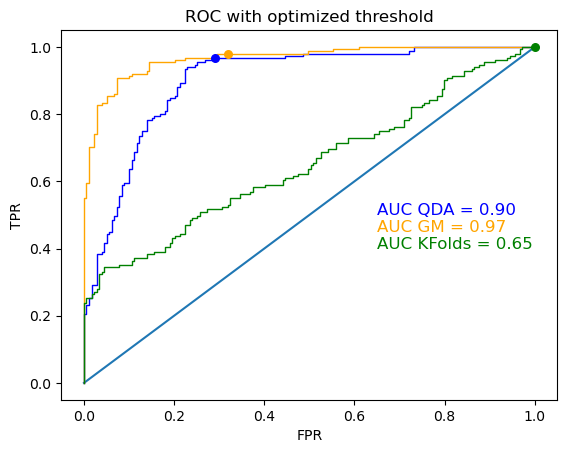

In [540]:
fig, ax = plt.subplots()
ax.set_xlabel('FPR');
ax.set_ylabel('TPR');
ax.set_title('ROC with optimized threshold')
ax.plot([0,1],[0,1]);

ax.plot(fprs_qda_t,tprs_qda_t, color='blue', linewidth=1);
ax.scatter([fpr_qda_t],[tpr_qda_t],s = 30, edgecolor='blue', zorder=5, facecolor='blue');

ax.plot(fprs_gm_t, tprs_gm_t, color='orange', linewidth=1);
ax.scatter([fpr_gm_t],[tpr_gm_t],s = 30, edgecolor='orange', zorder=5, facecolor='orange');

ax.plot(fprs_kf_t, tprs_kf_t, color='green', linewidth=1);
ax.scatter([fpr_kf_t], [tpr_kf_t],s = 30, edgecolor='green', zorder=5, facecolor='green');

ax.text(0.65, 0.5, "AUC QDA = {:4.2f}".format(auc_qda_t), fontsize=12, color='blue');
ax.text(0.65, 0.45, "AUC GM = {:4.2f}".format(auc_gm_t), fontsize=12, color='orange');
ax.text(0.65, 0.4, "AUC KFolds = {:4.2f}".format(auc_kf_t), fontsize=12, color='green');

sb.glue('D_ROC',fig, "display", display=False);